# Project "Revenu des adults" (Adult income)

## <a name="setup"></a> Configuration générale

In [1]:
import os

print ('Projet : %s' %os.getcwd())

workingDir = '/Users/user/Documents/data_analysis/pycharm workspace/EILV'
os.chdir(workingDir)

projectDir = '%s/projects/adult-income/' %os.getcwd()


from utilities.ReportMagics import *

merged_report ='%srapport.ipynb' %projectDir
print ('Fichier de rapport: %s' %merged_report)

%reset_all

Projet : /Users/user/Documents/data_analysis/pycharm workspace/EILV/projects/adult-income
Fichier de rapport: /Users/user/Documents/data_analysis/pycharm workspace/EILV/projects/adult-income/rapport.ipynb


In [2]:
%%add_conf_code_to_report
import os
# workingDir = '.'
# os.chdir(workingDir)

conf_file = '%sconfig-adult-income.yaml' %projectDir
Sample_Size = 10000

export_dir = '%stmp/' %projectDir
print ('Fichier de configuration: %s' %conf_file)
print ("Dossier pour les rapports: %s" %export_dir)

Fichier de configuration: /Users/user/Documents/data_analysis/pycharm workspace/EILV/projects/adult-income/config-adult-income.yaml
Dossier pour les rapports: /Users/user/Documents/data_analysis/pycharm workspace/EILV/projects/adult-income/tmp/


### Importer les paquets nécessaires et configurer les paramètres de l'environnement

In [3]:
%%add_conf_code_to_report

import pandas as pd
import numpy as np
import os
#os.chdir(workingDir)
import collections
import matplotlib
import io
import sys
import operator

import nbformat as nbf
from IPython.core.display import HTML
from IPython.display import display
from ipywidgets import interact, interactive,fixed
from IPython.display import Javascript, display,HTML
from ipywidgets import widgets, VBox
import ipywidgets
import IPython
from IPython.display import clear_output
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
import errno
import seaborn as sns
from string import Template
from functools import partial
from collections import OrderedDict

# Utility Classes
from utilities.ConfUtility import * 
from utilities.ReportGeneration import *
from utilities.UniVarAnalytics import *
from utilities.MultiVarAnalytics import *

%matplotlib inline

#DEBUG=0

font={'family':'normal','weight':'normal','size':8}
matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('axes', titlesize=10)
sns.set_style('whitegrid')

print ('Importation finie !')

Importation finie !


### Définir certaines fonctions pour générer des rapports

In [4]:
%%add_conf_code_to_report

if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    
def gen_report(conf_md,conf_code, md, code, filename):
    ReportGeneration.write_report(conf_md, conf_code, md, code, report_name=filename)

def translate_code_commands(cell, exported_cols, composite=False):    
    new_code_store = []
    exported_cols = [each for each in exported_cols if each!='']   
    for each in exported_cols:       
        w,x,y = each.split(',')
        with open('log.txt','w') as fout:
            fout.write("Traitement de l'appel pour la colonne {}".format(each))
        temp=cell[0]

        new_line = temp.replace('interactive','apply').replace(
            "df=fixed(df)","df").replace("filename=fixed(filename)","'"+ReportMagic.var_files+"'").replace(
            "col1=w1","'"+w+"'").replace("col2=w2","'"+x+"'").replace("col3=w3","'"+y+"'").replace(
            "col3=fixed(w3)","'"+y+"'").replace(
            "Export=w_export","False").replace("conf_dict=fixed(conf_dict)","conf_dict")       
        new_line = new_line.replace("df,","[df,")
        new_line = new_line[:len(new_line)-1]+"])"
        new_line = new_line.replace("apply(","").replace(", [", "(*[")
        new_code_store.append(new_line)        
    return new_code_store

def add_to_report(section='', task=''):
    print ('Section {}, tâche {} ajoutée pour la génération de rapports'.format(section ,task))

def trigger_report(widgets,export_cols_file, output_report, no_widgets=1, md_text=''):
    exported_cols = []
    with open(export_cols_file,'r') as fin:
        for each in fin:
            each = each.strip()
            if each and not each.isspace():
                exported_cols.append(each)
                
    exported_cols = list(set(exported_cols))
    conf_md, conf_code, md, code=%show_report 
    md = md_text
    cell = code
    new_code_store = translate_code_commands(cell,exported_cols)
    gen_report(conf_md,conf_code, md, new_code_store, filename=export_dir+output_report)
    
def silentremove(filename):
    try:
        os.remove(filename)
    except OSError as e: # this would be "except OSError, e:" before Python 2.6
        if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
            raise # re-raise exception if a different error occured

def handle_change(value):
    w_export.value=False

def getWidgetValue(w):
    w_value = ''
    try:
        w_value = w.value
    except:
        pass    
    return w_value

def handle_export(widget, w1, w2, w3, export_filename='temp.ipynb',md_text=''):    
    print ('Exportation réussie !')
    w1_value, w2_value, w3_value = \
        getWidgetValue(w1),getWidgetValue(w2),getWidgetValue(w3)
    st = ','.join(str(each) for each in [w1_value, w2_value, w3_value])
    with open(filename,'a') as fout:
        fout.write(st+'\n')
    trigger_report(w1_value, filename, export_filename, False, md_text=md_text)  
    
            

## <a name="read and summarize"></a> Lecture récapitulative des données

### Lire les données et déduire les types de colonnes

In [5]:
%%add_conf_code_to_report

conf_dict = ConfUtility.parse_yaml(conf_file)

# Read in data from local file or SQL server
if 'DataSource' not in conf_dict:
    df=pd.read_csv('%s%s' %(projectDir,conf_dict['DataFilePath'][0]), skipinitialspace=True)
else:
    import pyodbc
    cnxn = pyodbc.connect('driver=MySQL ODBC 3.51 Driver;server={};database={};Uid={};Pwd={}'.format(
            conf_dict['Server'], conf_dict['Database'],conf_dict['Username'],conf_dict['Password']))
    df = pd.read_sql(conf_dict['Query'],cnxn)

# Making sure that we are not reading any extra column
df = df[[each for each in df.columns if 'Unnamed' not in each]]

# Sampling Data if data size is larger than 10k
df0 = df # df0 is the unsampled data. Will be used in data exploration and analysis where sampling is not needed
         # However, keep in mind that your final report will always be based on the sampled data. 
if Sample_Size < df.shape[0]:
    df = df.sample(Sample_Size)

# change float data types
if 'FloatDataTypes' in conf_dict:   
    for col_name in conf_dict['FloatDataTypes']:
        df[col_name] = df[col_name].astype(float)      
        
# Getting the list of categorical columns if it was not there in the yaml file
if 'CategoricalColumns' not in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(list(df.select_dtypes(exclude=[np.number]).columns)))

# Getting the list of numerical columns if it was not there in the yaml file
if 'NumericalColumns' not in conf_dict:
    conf_dict['NumericalColumns'] = list(df.select_dtypes(include=[np.number]).columns)    

# Exclude columns that we do not need
if 'ColumnsToExclude' in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(conf_dict['CategoricalColumns'])-set(conf_dict['ColumnsToExclude']))
    conf_dict['NumericalColumns'] = list(set(conf_dict['NumericalColumns'])-set(conf_dict['ColumnsToExclude']))

# Ordering the categorical variables according to the number of unique categories
filtered_cat_columns = []
temp_dict = {}
for cat_var in conf_dict['CategoricalColumns']:
    temp_dict[cat_var] = len(np.unique(df[cat_var]))
sorted_x = sorted(temp_dict.items(), key=operator.itemgetter(0), reverse=True)
conf_dict['CategoricalColumns'] = [x for (x,y) in sorted_x]

ConfUtility.dict_to_htmllist(conf_dict,['Target','CategoricalColumns','NumericalColumns'])

### Lister les n-premières lignes (par défault, n=5)

In [6]:
%%add_conf_code_to_report
def custom_head(df,NoOfRows):
    return HTML(df.head(NoOfRows).style.set_table_attributes("class='table'").render())
i = interact(custom_head,df=fixed(df0), NoOfRows=ipywidgets.IntSlider(min=0, max=1000, step=1, \
                                                                     value=5, description='Nombre de ligne'))

interactive(children=(IntSlider(value=5, description='Nombre de ligne', max=1000), Output()), _dom_classes=('w…

### Afficher les dimensions des données (lignes, colonnes)

In [7]:
%%add_conf_code_to_report
print ('{} lignes | {} colonnes'.format(df0.shape[0],df0.shape[1]))

32561 lignes | 15 colonnes


### Imprimer les noms des variables (colonnes)

In [60]:
%%add_conf_code_to_report
col_names = ','.join(each for each in list(df.columns))
print("Les variables sont :" + col_names)

Les variables sont :age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,label_IsOver50K


### Afficher les types de colonnes

In [61]:
%%add_conf_code_to_report
print("Types des variables:")
df.dtypes

Types des variables:


age                 int64
workclass          object
fnlwgt              int64
education          object
educationnum        int64
maritalstatus      object
occupation         object
relationship       object
race               object
sex                object
capitalgain         int64
capitalloss         int64
hoursperweek        int64
nativecountry      object
label_IsOver50K     int64
dtype: object

## <a name="individual variable"></a>Extraire les statistiques descriptives de chaque colonne

In [62]:
%%add_conf_code_to_report
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

temp_df = df0.describe().T
missing_df = pd.DataFrame(df0.apply(num_missing, axis=0)) 
missing_df.columns = ['données manquantes']
unq_df = pd.DataFrame(df0.apply(num_unique, axis=0))
unq_df.columns = ['unique']
types_df = pd.DataFrame(df0.dtypes)
types_df.columns = ['Type de données']

### Afficher les statistiques descriptives des variables quantitatives

In [63]:
%%add_conf_code_to_report
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
summary_df

,count,mean,std,min,25%,50%,75%,max,données manquantes,unique,Type de données
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0,0,73,int64
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0,0,21648,int64
educationnum,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0,0,16,int64
capitalgain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0,0,119,int64
capitalloss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0,0,92,int64
hoursperweek,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0,0,94,int64
label_IsOver50K,32561.0,0.240810,0.427581,0.0,0.0,0.0,0.0,1.0,0,2,int64


### Afficher les statistiques descriptives des variables qualitatives

In [64]:
%%add_conf_code_to_report
col_names = list(types_df.index) #Get all col names
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index: #Find the indices of columns in Categorical columns
    if col_names[i] in conf_dict['CategoricalColumns']:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
summary_df_cat

,données manquantes,unique,Type de données
workclass,0,9,object
education,0,16,object
maritalstatus,0,7,object
occupation,0,15,object
relationship,0,6,object
race,0,5,object
sex,0,2,object
nativecountry,0,42,object
label_IsOver50K,0,2,int64


## <a name="individual variables"></a>Explorer des variables individuelles

### Explorer la variable cible

HBox(children=(Dropdown(description=u'Variable cible:', options=('label_IsOver50K',), value='label_IsOver50K'), Checkbox(value=False, description=u'Export'), Output()))

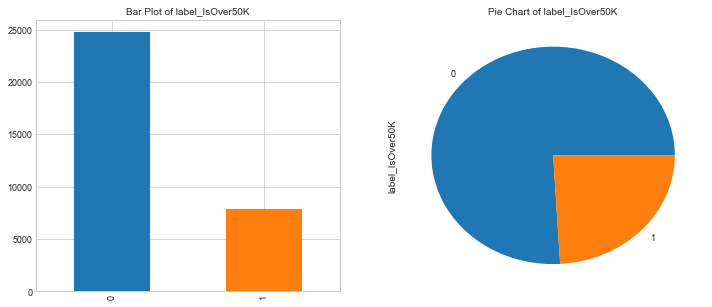

In [65]:
md_text = '## Variable cible'
filename = 'tmp/target_variables.csv'
export_filename = 'target_report2.ipynb'

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    w1_value,w2_value,w3_value = '','',''
    w1, w2, w3, w4 = None, None, None, None
    silentremove(filename)    
    w1 = widgets.Dropdown(
        options=[conf_dict['Target']],
        value=conf_dict['Target'],
        description='Variable cible:',
    )

    ReportMagic.var_files = filename
    w_export = widgets.Button(description='Export', value='Export')
    handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)      
    w1.observe(handle_change,'value')
    w_export.on_click(handle_export_partial)

    %reset_report
    %add_interaction_code_to_report 
    i = interactive(TargetAnalytics.custom_barplot, df=fixed(df), \
                                                    filename=fixed(filename), col1=w1)
    hbox = widgets.HBox(i.children)
    display(hbox)
    hbox.on_displayed(TargetAnalytics.custom_barplot(df=df0, filename=filename, col1=w1.value, Export=w_export))
else:
    w1_value, w2_value, w3_value = '', '', ''
    w1, w2, w3, w4 = None, None, None, None
    silentremove(filename) 
    w1 = widgets.Dropdown(
            options=[conf_dict['Target']],
            value=conf_dict['Target'],
            description='Variable cible:',
        )
    w_export = widgets.Button(description='Export', value='Export')
    handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
    w1.observe(handle_change,'value')
    w_export.on_click(handle_export_partial)

    %reset_report
    %add_interaction_code_to_report 
    i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), filename=fixed(filename),\
                                                    col1=w1)
    hbox = widgets.HBox(i.children)
    display(hbox)
    hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, filename=filename, col1=w1.value, Export=w_export))

### Explorer des variables numériques individuelles et tester la normalité (sur des données échantillonnées)

In [80]:
md_text = '## Visualiser les variables numériques individuelles (sur les données échantillonnées)'
filename = ReportMagic.var_files='tmp/numeric_variables.csv'
export_filename = 'numeric_report2.ipynb'
w1_value, w2_value, w3_value = '', '', ''
w1, w2, w3, w4 = None, None, None, None
silentremove(filename) 
w1 = widgets.Dropdown(
        options=conf_dict['NumericalColumns'],
        value=conf_dict['NumericalColumns'][0],
        description='Numeric Variable:',
    )
w_export = widgets.Button(description='Export', value='Export')
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report 
i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), filename=fixed(filename),\
                                                col1=w1)#, Export=w_export
# hbox = widgets.HBox(i.children)
# display(hbox)
display(i)
# hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, filename=filename, col1=w1.value, Export=w_export))

interactive(children=(Dropdown(description=u'Numeric Variable:', options=('age', 'fnlwgt', 'educationnum', 'capitalgain', 'capitalloss', 'hoursperweek'), value='age'), Checkbox(value=False, description=u'Export'), Output()), _dom_classes=('widget-interact',))

### Explorer des variables qualitatives individuelles (triées par fréquences)

In [67]:
w_export = None
md_text = '## Visualiser les Variables qualitatives individuelles'
filename = ReportMagic.var_files='tmp/categoric_variables.csv'
export_filename = 'categoric_report2.ipynb'

w1_value, w2_value, w3_value = '', '', ''
w1, w2, w3, w4 = None, None, None, None
silentremove(filename) 
w1 = widgets.Dropdown(
    options = conf_dict['CategoricalColumns'],
    value = conf_dict['CategoricalColumns'][0],
    description = 'Categorical Variable:',
)

w_export = widgets.Button(description='Export')
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe (handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report 
i = interactive(CategoricAnalytics.custom_barplot, df=fixed(df),\
                                                filename=fixed(filename), col1=w1)

# hbox = widgets.HBox(i.children)
# display(hbox)
display(i)
# hbox.on_displayed(CategoricAnalytics.custom_barplot(df=df0, filename=filename, col1=w1.value, Export=w_export))

interactive(children=(Dropdown(description=u'Categorical Variable:', options=('workclass', 'sex', 'relationship', 'race', 'occupation', 'nativecountry', 'maritalstatus', 'label_IsOver50K', 'education'), value='workclass'), Checkbox(value=False, description=u'Export'), Output()), _dom_classes=('widget-interact',))

## <a name="multiple variables"></a>Explorer les interactions entre les variables

### <a name="rank variables"></a>Classer les variables en fonction des relations linéaires avec la variable de référence (sur les données échantillonnées)

In [68]:
md_text = 'Classer les variables en fonction des relations linéaires avec la variable de référence (sur les données échantillonnées)'
filename = ReportMagic.var_files='tmp/rank_associations.csv'
export_filename = 'rank_report2.ipynb'
silentremove(filename)
cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] + conf_dict['CategoricalColumns'] #Make target the default reference variable
cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
w1 = widgets.Dropdown(    
    options=cols_list,
    value=cols_list[0],
    description='Ref Var:'
)
w2 = ipywidgets.Text(value="5", description='Top Num Vars:')
w3 = ipywidgets.Text(value="5", description='Top Cat Vars:')
w_export = widgets.Button(description='Export', value='Export')
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)
w1.observe (handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report 
i = interactive(InteractionAnalytics.rank_associations, df=fixed(df), \
                                                conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3, Export=w_export)
# hbox = widgets.HBox(i.children)
# display(hbox)
display(i)
#hbox.on_displayed(InteractionAnalytics.rank_associations(df=df, conf_dict=conf_dict, col1=w1.value, col2=w2.value, col3=w3.value, Export=w_export))

ValueError: Button(description=u'Export', style=ButtonStyle()) cannot be transformed to a widget

### <a name="two categorical"></a>Explorer les interactions entre les variables qualitatives

In [81]:
md_text = '## Explorer les interactions entre les variables qualitatives'
filename = ReportMagic.var_files='tmp/cat_interactions.csv'
export_filename = 'cat_interactions_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['CategoricalColumns']
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Var Qual 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Var Qual 2:'
)
w_export = widgets.Button(description='Export', value="Export")
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w2.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report 
i = interactive(InteractionAnalytics.categorical_relations, df=fixed(df), \
                                         filename=fixed(filename), col1=w1, col2=w2)
# hbox = widgets.HBox(i.children)
# display(hbox)
display(i)
# hbox.on_displayed(InteractionAnalytics.categorical_relations(df=df0, filename=filename, col1=w1.value, col2=w2.value, Export=w_export))

interactive(children=(Dropdown(description=u'Var Qual 1:', options=('label_IsOver50K', 'workclass', 'sex', 'relationship', 'race', 'occupation', 'nativecountry', 'maritalstatus', 'education'), value='label_IsOver50K'), Dropdown(description=u'Var Qual 2:', index=1, options=('label_IsOver50K', 'workclass', 'sex', 'relationship', 'race', 'occupation', 'nativecountry', 'maritalstatus', 'education'), value='workclass'), Checkbox(value=False, description=u'Export'), Output()), _dom_classes=('widget-interact',))

### <a name="two numerical"></a>Explorer les interactions entre les variables quantitatives (sur les données échantillonnées)

In [70]:
md_text = '## Explorer les interactions entre les variables quantitatives (sur les données échantillonnées)'
filename = ReportMagic.var_files='tmp/numerical_interactions.csv'
export_filename = 'numerical_interactions_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['NumericalColumns']
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Var quanti 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Var quanti 2:'
)
w_export = widgets.Button(description='Export', value="Export")
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w2.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report 
i = interactive(InteractionAnalytics.numerical_relations, df=fixed(df), \
                                         col1=w1, col2=w2)
# hbox = widgets.HBox(i.children)
# display(hbox)
display(i)
# hbox.on_displayed(InteractionAnalytics.numerical_relations(df, col1=w1.value, col2=w2.value, Export=w_export))

interactive(children=(Dropdown(description=u'Var quanti 1:', options=('age', 'fnlwgt', 'educationnum', 'capitalgain', 'capitalloss', 'hoursperweek'), value='age'), Dropdown(description=u'Var quanti 2:', index=1, options=('age', 'fnlwgt', 'educationnum', 'capitalgain', 'capitalloss', 'hoursperweek'), value='fnlwgt'), Checkbox(value=False, description=u'Export'), Output()), _dom_classes=('widget-interact',))

### Explorer la matrice de corrélation entre les variables quantitatives

In [71]:
md_text = '## Explorer la matrice de corrélation entre les variables quantitatives'
filename = ReportMagic.var_files='tmp/numerical_corr.csv'
export_filename = 'numerical_correlations_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None
w1 = widgets.Dropdown(
    options=['pearson','kendall','spearman'],
    value='pearson',
    description='Methode:'
)
w_export = widgets.Button(description='Export', value='Export')
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report 
i = interactive(InteractionAnalytics.numerical_correlation, df=fixed(df), conf_dict=fixed(conf_dict),\
                                         col1=w1)

# hbox = widgets.HBox(i.children)
# display(hbox)
display(i)
# hbox.on_displayed(InteractionAnalytics.numerical_correlation(df0, conf_dict=conf_dict, col1=w1.value, Export=w_export))

interactive(children=(Dropdown(description=u'Methode:', options=('pearson', 'kendall', 'spearman'), value='pearson'), Checkbox(value=False, description=u'Export'), Output()), _dom_classes=('widget-interact',))

### <a name="numerical and categorical"></a>Explorer les interactions entre les variables quantitative et qualitative

In [72]:
md_text = '## Explorer les interactions entre les variables quantitative et qualitative'
filename = ReportMagic.var_files = 'tmp/nc_int.csv'
export_filename = 'nc_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['NumericalColumns']
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Quantitative:'
)

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['CategoricalColumns']
    
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Qualitative:'
)
w_export = widgets.Button(description='Export', value=False, options=[True, False])
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)      
w1.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report 
i = interactive(InteractionAnalytics.nc_relation, df=fixed(df), \
                                                conf_dict=fixed(conf_dict), col1=w1, col2=w2, \
                                                col3=fixed(w3))

# hbox = widgets.HBox(i.children)
# display(hbox)
display(i)
# hbox.on_displayed(InteractionAnalytics.nc_relation(df0, conf_dict, col1=w1.value, col2=w2.value, Export=w_export))

interactive(children=(Dropdown(description=u'Quantitative:', options=('age', 'fnlwgt', 'educationnum', 'capitalgain', 'capitalloss', 'hoursperweek'), value='age'), Dropdown(description=u'Qualitative:', options=('label_IsOver50K', 'workclass', 'sex', 'relationship', 'race', 'occupation', 'nativecountry', 'maritalstatus', 'education'), value='label_IsOver50K'), Checkbox(value=False, description=u'Export'), Output()), _dom_classes=('widget-interact',))

### <a name="two numerical and categorical"></a>Explorer les interactions entre deux variables quantitatives et une variable qualitatives (sur des données échantillonnées)

In [73]:
md_text = '## Explorer les interactions entre deux variables quantitatives et une variable qualitatives (sur des données échantillonnées)'
filename = ReportMagic.var_files='tmp/nnc_int.csv'
export_filename = 'nnc_report2.ipynb'
silentremove(filename) 
w1, w2, w3, w4 = None, None, None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['NumericalColumns']
    
w1 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Var Qttv 1:'
)
w2 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[1],
    description = 'Var Qttv 2:'
)

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['CategoricalColumns']
    
w3 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Legend Cat Var:'
)
w_export = widgets.Button(description='Export', value=False, options=[True, False])
handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
w1.observe(handle_change,'value')
w_export.on_click(handle_export_partial)

%reset_report
%add_interaction_code_to_report 
i = interactive(InteractionAnalytics.nnc_relation, df=fixed(df),\
                                                conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3)
# hbox = widgets.HBox(i.children)
# display(hbox)
display(i)
# hbox.on_displayed(InteractionAnalytics.nnc_relation(df, conf_dict, col1=w1.value,col2=w2.value, col3=w3.value, Export=w_export))

interactive(children=(Dropdown(description=u'Var Qttv 1:', options=('age', 'fnlwgt', 'educationnum', 'capitalgain', 'capitalloss', 'hoursperweek'), value='age'), Dropdown(description=u'Var Qttv 2:', index=1, options=('age', 'fnlwgt', 'educationnum', 'capitalgain', 'capitalloss', 'hoursperweek'), value='fnlwgt'), Dropdown(description=u'Legend Cat Var:', options=('label_IsOver50K', 'workclass', 'sex', 'relationship', 'race', 'occupation', 'nativecountry', 'maritalstatus', 'education'), value='label_IsOver50K'), Checkbox(value=False, description=u'Export'), Output()), _dom_classes=('widget-interact',))

## <a name="pca"></a>Visualiser les données quantitatives par analyse en composantes principales (sur les données échantillonnées)

### Projection 2D par ACP

In [74]:
num_numeric = len(conf_dict['NumericalColumns'])
if  num_numeric > 3:
    md_text = "## Données de projet sur l'espace des composants principaux 2-D"
    filename = ReportMagic.var_files = 'tmp/numerical_pca.csv'
    export_filename = 'numerical_pca_report2.ipynb'
    silentremove(filename) 
    
    w1, w2, w3, w4, w5 = None, None, None, None, None
    if conf_dict['Target'] in conf_dict['CategoricalColumns']:
        cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
        cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
    else:
        cols_list = conf_dict['CategoricalColumns']
    w1 = widgets.Dropdown(
        options = cols_list,
        value = cols_list[0],
        description = 'Legend:',
        width = 10
    )
    w2 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '1',
        width = 1,
        description='PC at X-Axis:'
    )
    w3 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '2',
        description = 'PC at Y-Axis:'
    )
    w_export = widgets.Button(description='Export', value=False, options=[True, False])
    handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, export_filename=export_filename, md_text=md_text)       
    w1.observe(handle_change,'value')
    w_export.on_click(handle_export_partial)
    
    %reset_report
    %add_interaction_code_to_report 
    i = interactive(InteractionAnalytics.numerical_pca, df=fixed(df),\
                                                    conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3)

    
    # hbox = widgets.HBox(i.children)
    # display(hbox)
    display(i)
    #hbox.on_displayed(InteractionAnalytics.numerical_pca(df, conf_dict=conf_dict, col1=w1.value, col2=w2.value, col3=w3.value, Export=w_export))

interactive(children=(Dropdown(description=u'Legend:', options=('label_IsOver50K', 'workclass', 'sex', 'relationship', 'race', 'occupation', 'nativecountry', 'maritalstatus', 'education'), value='label_IsOver50K'), Dropdown(description=u'PC at X-Axis:', options=('1', '2', '3', '4', '5', '6'), value='1'), Dropdown(description=u'PC at Y-Axis:', index=1, options=('1', '2', '3', '4', '5', '6'), value='2'), Checkbox(value=False, description=u'Export'), Output()), _dom_classes=('widget-interact',))

### Projection 3D par ACP

In [75]:
md_text = "##  Données de projet vers l'espace des composants principaux 3D (sur les données échantillonnées)"
if len(conf_dict['NumericalColumns']) > 3:
    filename = ReportMagic.var_files='tmp/pca3d.csv'
    export_filename = 'pca3d_report2.ipynb'
    silentremove(filename) 
    if conf_dict['Target'] in conf_dict['CategoricalColumns']:
        cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
        cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
    else:
        cols_list = conf_dict['CategoricalColumns']
    w1, w2, w3, w4 = None, None, None, None
    w1 = widgets.Dropdown(
        options=cols_list,
        value=cols_list[0],
        description='Legend:'
    )
    w2 = ipywidgets.IntSlider(min=-180, max=180, step=5, value=30, description='Angle')
    w_export = widgets.Button(description='Export',value='Export')
    handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, \
                                    export_filename=export_filename, md_text=md_text)     
    w1.observe(handle_change,'value')
    w_export.on_click(handle_export_partial)
    
    %reset_report
    %add_interaction_code_to_report 
    i = interactive(InteractionAnalytics.pca_3d, df=fixed(df), conf_dict=fixed(conf_dict),\
                                              col1=w1, col2=w2, col3=fixed(w3))

    # hbox = widgets.HBox(i.children)
    # display(hbox)
    display(i)
    #hbox.on_displayed(InteractionAnalytics.pca_3d(df,conf_dict,col1=w1.value,col2=w2.value,Export=w_export))

interactive(children=(Dropdown(description=u'Legend:', options=('label_IsOver50K', 'workclass', 'sex', 'relationship', 'race', 'occupation', 'nativecountry', 'maritalstatus', 'education'), value='label_IsOver50K'), IntSlider(value=30, description=u'Angle', max=180, min=-180, step=5), Checkbox(value=False, description=u'Export'), Output()), _dom_classes=('widget-interact',))

## <a name="report"></a>Générer le rapport de données

In [79]:
filenames = ['target_report2.ipynb', 'numeric_report2.ipynb', 'categoric_report2.ipynb', 'rank_report2.ipynb',
           'cat_interactions_report2.ipynb', 'numerical_interactions_report2.ipynb',
             'numerical_correlations_report2.ipynb', 'nc_report2.ipynb',
             'nnc_report2.ipynb', 'numerical_pca_report2.ipynb', 'pca3d_report2.ipynb'
           ]

def merge_notebooks():
    print ('Ecriture du rapport en cours ... ')
    merged = None
    for fname in filenames:
        print ('fichier %s' %fname)
        try:
            print ('Traitement en cours {}'.format(export_dir+fname))
            with io.open(export_dir+fname, 'r', encoding='utf-8') as f:
                nb = nbf.read(f, as_version=4)
            if merged is None:
                merged = nb
            else:
                merged.cells.extend(nb.cells[2:])
        except:
            print ('Attemtopm: fichier introuvable', export_dir+'//'+fname, ', continue...')
    if not hasattr(merged.metadata, 'name'):
        merged.metadata.name = ''
    merged.metadata.name += "_merged"
    with open(merged_report, 'w') as f:
        nbf.write(merged, f)

def gen_merged_report(b):
    print("En cours")
    merge_notebooks()
    
button=widgets.Button(description='Generate Final Report')
button.on_click(gen_merged_report)
display(button)

Button(description=u'Generate Final Report', style=ButtonStyle())

## <a name="show hide codes"></a>Show/Hide the Source Codes

In [ ]:
# Provide the path to the yaml file relative to the working directory
display(HTML('''<style>
    .widget-label { min-width: 20ex !important; }
    .widget-text { min-width: 60ex !important; }
</style>'''))

#Toggle Code
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();

 } else {
 $('div.input').show();

 }
 code_show = !code_show
} 
//$( document ).ready(code_toggle);//commenting code disabling by default
</script>
<form action = "javascript:code_toggle()"><input type="submit" value="Toggle Raw Code"></form>''')